Training Simple RNN...
Epoch 0, Loss: 1.0385
Epoch 50, Loss: 1.0137
Epoch 100, Loss: 1.0137
Epoch 150, Loss: 1.0138
Epoch 200, Loss: 1.0138
Epoch 250, Loss: 1.0138
Epoch 300, Loss: 1.0138
Epoch 350, Loss: 1.0138
Epoch 400, Loss: 1.0138
Epoch 450, Loss: 1.0138

Testing RNN:
Input: [1, 0, 1, 0, 1] -> Predicted: 1, Expected: 1
Input: [0, 1, 0, 1, 0] -> Predicted: 1, Expected: 1
Input: [1, 1, 0, 0, 1] -> Predicted: 1, Expected: 1
Input: [0, 0, 1, 1, 0] -> Predicted: 1, Expected: 1


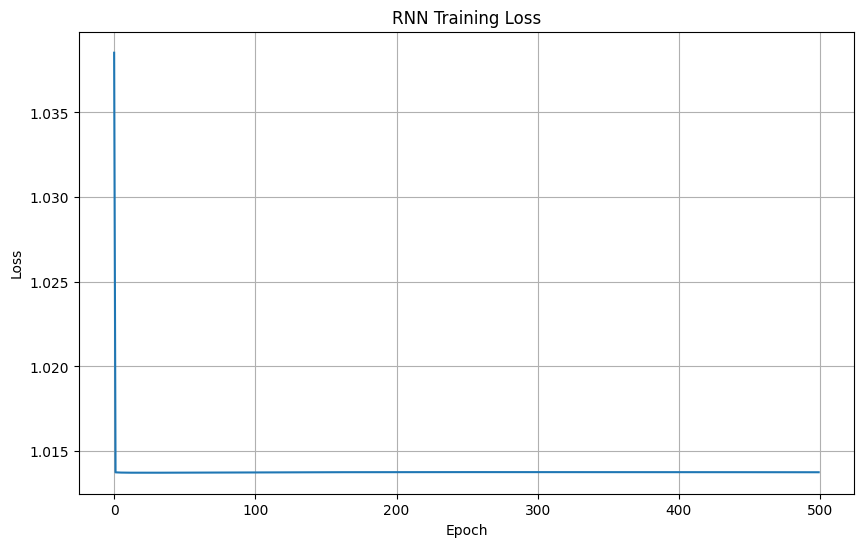

In [9]:
import numpy as np
import matplotlib.pyplot as plt

class SimpleRNN:
    def __init__(self, input_size=1, hidden_size=10, output_size=1, learning_rate=0.01):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        
        # Initialize weights
        self.Wax = np.random.randn(input_size, hidden_size) * 0.01  # X(m,1) * Wax(1,10) -> (m,10)
        self.Waa = np.random.randn(hidden_size, hidden_size) * 0.01 # A{t-1}(m,10) * Waa(10,10) -> (m,10)
        self.Wya = np.random.randn(hidden_size, output_size) * 0.01 # A{t}(m,10) * Wya(10,1) -> (m,1)
        
        # Initialize biases
        self.ba = np.zeros((1, hidden_size)) # 1x10
        self.by = np.zeros((1, output_size)) # 1x1
        
        # Storage for backward pass
        self.last_inputs = None
        self.last_as = None
        self.last_output = None
        
    def forward(self, inputs):
        """
        Forward pass through the RNN
        inputs: list of input vectors (sequence)
        """
        a = np.zeros((1, self.hidden_size))  # 1x10 A{0} // A{t-1} to be generic
        self.last_inputs = inputs
        self.last_as = {0: a}
        
        # Forward pass for each time step
        for t, x in enumerate(inputs):
            x = x.reshape(1, -1)  # ensure row vector (1, input_size)
            a = np.tanh(np.dot(x, self.Wax) + np.dot(a, self.Waa) + self.ba)
            self.last_as[t + 1] = a
            
        # Output only at the last time step
        y = np.dot(a, self.Wya) + self.by
        self.last_output = y  # Store output for backward pass
        return y, a
    
    def backward(self, target, learning_rate=None):
        """
        Backward pass (BPTT - Backpropagation Through Time)
        """
        if learning_rate is None:
            learning_rate = self.learning_rate
            
        if self.last_inputs is None:
            raise ValueError("Must call forward() before backward()")
            
        n = len(self.last_inputs)
        
        # Initialize gradients
        dWax = np.zeros_like(self.Wax)
        dWaa = np.zeros_like(self.Waa)
        dWya = np.zeros_like(self.Wya)
        dba = np.zeros_like(self.ba)
        dby = np.zeros_like(self.by)
        
        # Output layer gradients
        target = target.reshape(1, -1)  # shape = (1, output_size)
        y = self.last_output  # Use stored output
        
        dy = 2 * (y - target)  # derivative of MSE loss # 1 x output_size
        
        # Gradients for output layer
        dWya += np.dot(self.last_as[n].T, dy)  # (hidden_size, 1) * (1, output_size) -> (hidden_size, output_size)
        dby += dy  # (1, output_size)
        
        # Initialize hidden state gradient
        da = np.dot(dy, self.Wya.T)  # (1, output_size) * (output_size, hidden_size) -> (1, hidden_size)
        
        # Backpropagate through time
        for t in reversed(range(n)):
            # Gradient through tanh
            da_raw = (1 - self.last_as[t + 1] ** 2) * da  # (1, hidden_size)
            
            # Gradients for biases
            dba += da_raw  # (1, hidden_size)
            
            # Gradients for weights
            x_t = self.last_inputs[t].reshape(1, -1)  # (1, input_size)
            dWax += np.dot(x_t.T, da_raw)  # (input_size, 1) * (1, hidden_size) -> (input_size, hidden_size)
            dWaa += np.dot(self.last_as[t].T, da_raw)  # (hidden_size, 1) * (1, hidden_size) -> (hidden_size, hidden_size)
            
            # Gradient for previous hidden state
            da = np.dot(da_raw, self.Waa.T)  # (1, hidden_size) * (hidden_size, hidden_size) -> (1, hidden_size)
        
        # Update weights
        self.Wax -= learning_rate * dWax
        self.Waa -= learning_rate * dWaa
        self.Wya -= learning_rate * dWya
        self.ba -= learning_rate * dba
        self.by -= learning_rate * dby
        
        return np.sum(dy ** 2)  # return loss

# Example usage: Simple sequence prediction
def create_simple_sequence():
    """Create a simple sequence: [1, 0, 1, 0, ...] -> next value"""
    sequence_length = 5
    sequences = []
    targets = []
    
    for _ in range(1000):
        # Random binary sequence
        seq = np.random.randint(0, 2, sequence_length)
        # Target: next value follows a simple pattern (XOR of last two)
        target = seq[-1] ^ seq[-2]  # XOR pattern
        
        sequences.append(seq)
        targets.append([target])
    
    return sequences, targets

def train_simple_rnn():
    sequences, targets = create_simple_sequence()
    rnn = SimpleRNN(input_size=1, hidden_size=10, output_size=1, learning_rate=0.01)
    
    losses = []
    for epoch in range(500):
        total_loss = 0
        
        for seq, target in zip(sequences, targets):
            inputs = [np.array([x]) for x in seq]
            target_array = np.array(target)
            
            # Explicit forward pass
            rnn.forward(inputs)
            # Then backward pass
            loss = rnn.backward(target_array)
            total_loss += loss
            
        avg_loss = total_loss / len(sequences)
        losses.append(avg_loss)
        
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")
    
    return rnn, losses

# Test the trained RNN
def test_rnn(rnn):
    test_sequences = [
        [1, 0, 1, 0, 1],  # should predict 1 (1 XOR 0)
        [0, 1, 0, 1, 0],  # should predict 1 (0 XOR 1)
        [1, 1, 0, 0, 1],  # should predict 1 (1 XOR 0)
        [0, 0, 1, 1, 0],  # should predict 1 (0 XOR 1)
    ]
    
    for seq in test_sequences:
        inputs = [np.array([x]) for x in seq]
        output, _ = rnn.forward(inputs)
        predicted = 1 if output[0, 0] > 0.5 else 0
        expected = seq[-1] ^ seq[-2]
        print(f"Input: {seq} -> Predicted: {predicted}, Expected: {expected}")

if __name__ == "__main__":
    print("Training Simple RNN...")
    rnn, losses = train_simple_rnn()
    
    print("\nTesting RNN:")
    test_rnn(rnn)
    
    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(losses)
    plt.title('RNN Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()